In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Bidirectional
from matplotlib import pyplot
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
data_f = open("features.pickle","rb")
data = pickle.load(data_f)
data_f.close()

In [ ]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)

(8732,) (8732,)


In [ ]:
X = np.empty([8732, 128])
for i in range(8732):
    X[i] = (X_[i])

In [ ]:
Y = to_categorical(Y)

In [ ]:
print(X.shape, Y.shape)

(8732, 128) (8732, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6549, 128) (2183, 128) (6549, 10) (2183, 10)


In [ ]:
X_train = X_train.reshape(6549, 16, 8)
X_test  = X_test.reshape(2183, 16, 8)

# X_train, X_test shape : (total # of training examples, sequence_length, input_dim)
# Y_train, Y_test shape : (total # of training examples, # output classes)

In [ ]:
def get_lstm_model():
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8)))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False))
    model.add(Dense(units=10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
def get_bi_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8))))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False))
    model.add((Dense(units=10, activation="softmax")))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [ ]:
def train_model(model):
    loss = list()
    accuracy = list()
    for _ in range(85):
        hist = model.fit(X_train, Y_train, epochs = 1, batch_size = 50, validation_data = (X_test, Y_test), verbose=1)
        loss.append(hist.history['loss'][0])
        accuracy.append(hist.history['accuracy'][0])
    return loss, accuracy

In [ ]:
loss_results = pd.DataFrame()
acc_results = pd.DataFrame()

In [ ]:
model1 = get_lstm_model()
loss_results['lstm'], acc_results['lstm'] = train_model(model1)

131/131 [==============================] - 1s 6ms/step - loss: 0.2895 - accuracy: 0.9088 - val_loss: 0.8041 - val_accuracy: 0.7810


In [ ]:
#model1.save("model_lstm.h5")
model1 = keras.models.load_model('/content/model_lstm.h5')
score, accuracy = model1.evaluate(X_test, Y_test, batch_size=50, verbose=1)
print(f" Test loss     : {score*100}\n Test accuracy : {accuracy*100}")

44/44 [==============================] - 0s 4ms/step - loss: 0.8041 - accuracy: 0.7810
 Test loss     : 80.41108250617981
 Test accuracy : 78.10352444648743


In [ ]:
model2 = get_bi_lstm_model()
loss_results['bi_lstm'], acc_results['bi_lstm'] = train_model(model2)

131/131 [==============================] - 1s 9ms/step - loss: 0.1973 - accuracy: 0.9400 - val_loss: 0.7438 - val_accuracy: 0.8003


In [ ]:
#model2.save("model_bi_lstm.h5")
model1 = keras.models.load_model('/content/model_bi_lstm.h5')
score, accuracy = model2.evaluate(X_test, Y_test, batch_size=50, verbose=1)
print(f" Test loss     : {score*100}\n Test accuracy : {accuracy*100}")

44/44 [==============================] - 0s 4ms/step - loss: 0.7438 - accuracy: 0.8003
 Test loss     : 74.37924146652222
 Test accuracy : 80.02748489379883


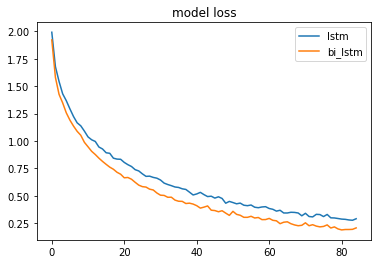

In [ ]:
loss_results.plot()
pyplot.title('model loss')
pyplot.show()

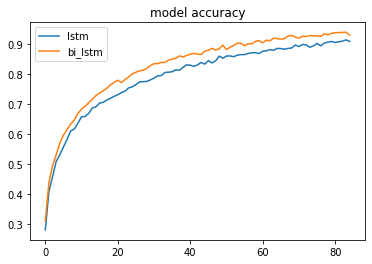

In [ ]:
acc_results.plot()
pyplot.title('model accuracy')
pyplot.show()

In [ ]:
import librosa

class_labels = ['airconditioner', 'carhorn', 'childrenplaying', 'dogbark', 
                'drilling', 'engineidling', 'gunshot', 'jackhammer',
                'siren', 'street_music']

In [ ]:
def prediction(path):
  K, sample_rate = librosa.load(path, res_type='kaiser_fast')
  test = np.mean(librosa.feature.melspectrogram(y=K, sr=sample_rate).T,axis=0)
  test = np.array(test)
  test = test.transpose()
  test = test.reshape(16, 8)
  q1 = np.argmax(model1.predict(np.array([test,]))[0])
  q2 = np.argmax(model2.predict(np.array([test,]))[0])
  return class_labels[q1], class_labels[q1] 

In [ ]:
path = '/content/001ca53d.wav'
sound = prediction(path)
print(f'LSTM prediction   : {sound[0]}\nBiLSTM prediction : {sound[0]}')

LSTM prediction   : street_music
BiLSTM prediction : street_music
